<a href="https://colab.research.google.com/github/HaykalRamadhan/forecasting/blob/main/UP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Forecasting Per Monthly

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load data
ct = pd.read_csv('/content/drive/MyDrive/UP/sample_data/Monthly_Sales_Summary.csv')

In [ ]:
# Convert 'Transaksi' (string YYYY-MM) to numeric value (year + month/12)
ct[['Year', 'Month']] = ct['Transaksi'].str.split('-', expand=True)
ct['Year'] = ct['Year'].astype(int)
ct['Month'] = ct['Month'].astype(int)
ct['Transaksi_Numeric'] = ct['Year'] + (ct['Month'] / 12)

In [ ]:
# Sort by numeric
ct = ct.sort_values(by="Transaksi_Numeric")

In [ ]:
# Define X and Y in array
x = np.array(ct["Transaksi_Numeric"])
y = np.array(ct["Total"])

print(x)
print(y)

[2023.91666667 2024.         2024.08333333 2024.16666667 2024.25
 2024.33333333 2024.41666667 2024.5        2024.58333333 2024.66666667
 2024.75       2024.83333333 2024.91666667 2025.         2025.08333333
 2025.16666667]
[  108396.56  2686599.    8708216.79 11582148.11 11881916.18 14772076.59
 14116645.83 15660415.44 14234010.85 15790109.88 13163186.6  14519152.52
 15343173.46 14234703.68 13867183.9  11788947.78]


In [ ]:
# Function to compute R2 manually
def compute_r2(y_true, y_predict):
    sse = sum((y_true - y_predict) ** 2)
    tss = (len(y_true) - 1) * np.var(y_true, ddof=1)
    r2_score = 1 - (sse / tss)
    return r2_score

In [ ]:
# Future prediction points (next 3 months)
last_year = ct['Year'].max()
last_month = ct[ct['Year'] == last_year]['Month'].max()
future_dates = []
for i in range(1, 4):
    new_month = last_month + i
    new_year = last_year
    if new_month > 12:
        new_year += 1
        new_month -= 12
    future_numeric = new_year + (new_month / 12)
    future_dates.append(future_numeric)
x2 = np.array(future_dates)


--- Polynomial Regression Degree 2 ---
R2 Score: 0.8993
Future Predictions:
Transaksi 2025-03: Predicted Total = 9277098.75
Transaksi 2025-04: Predicted Total = 7043623.98
Transaksi 2025-05: Predicted Total = 4491853.56


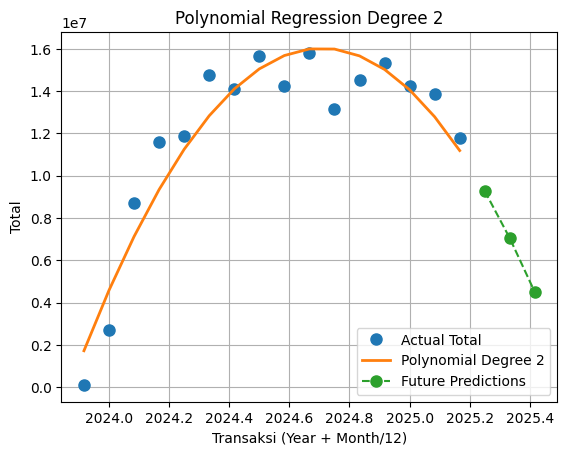


--- Polynomial Regression Degree 3 ---
R2 Score: 0.9493
Future Predictions:
Transaksi 2025-03: Predicted Total = 13084896.00
Transaksi 2025-04: Predicted Total = 13539424.00
Transaksi 2025-05: Predicted Total = 14422144.00


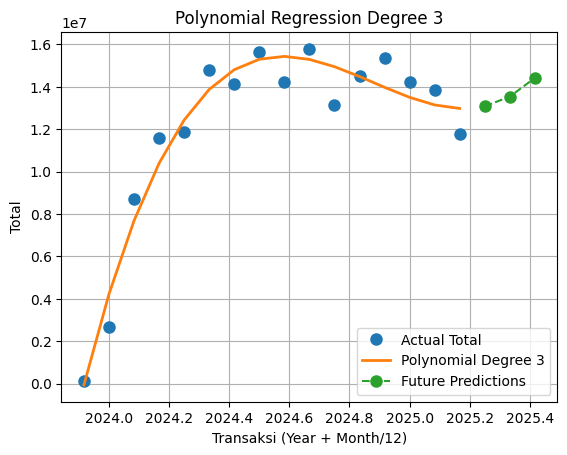


--- Polynomial Regression Degree 4 ---
R2 Score: 0.9493
Future Predictions:
Transaksi 2025-03: Predicted Total = 13085472.00
Transaksi 2025-04: Predicted Total = 13540448.00
Transaksi 2025-05: Predicted Total = 14424096.00


<ipython-input-9-8209e024abb8>:5: RankWarning: Polyfit may be poorly conditioned
  AB = np.polyfit(x, y, degree)


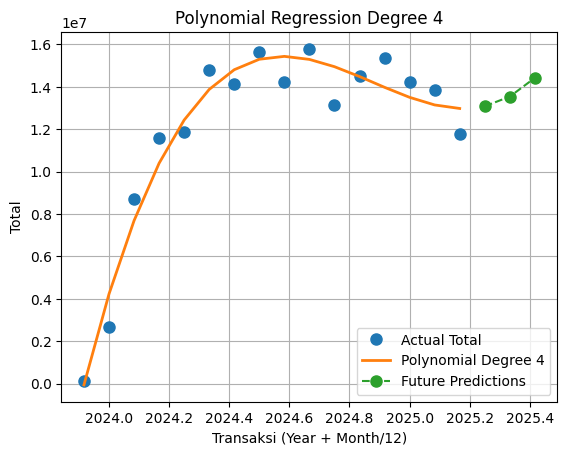

In [ ]:
# Polynomial regression degrees 2, 3, 4
for degree in [2, 3, 4]:
    print(f"\n--- Polynomial Regression Degree {degree} ---")

    AB = np.polyfit(x, y, degree)
    func = np.poly1d(AB)

    y_p = func(x)   # prediction for existing points
    y_p2 = func(x2) # prediction for future points

    # Compute R2
    r2 = compute_r2(y, y_p)
    print(f"R2 Score: {r2:.4f}")
    print("Future Predictions:")
    for trans, pred in zip(x2, y_p2):
        year = int(trans)
        month = int(round((trans - year) * 12))
        if month == 0:
            month = 12
            year -= 1
        print(f"Transaksi {year}-{str(month).zfill(2)}: Predicted Total = {pred:.2f}")

    plt.plot(x, y, linestyle="none", marker='o', markersize=8, label='Actual Total')
    plt.plot(x, y_p, linewidth=2, label=f'Polynomial Degree {degree}')
    plt.plot(x2, y_p2, marker='o', linestyle='dashed', markersize=8, label='Future Predictions')
    plt.xlabel('Transaksi (Year + Month/12)')
    plt.ylabel('Total')
    plt.title(f'Polynomial Regression Degree {degree}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load daily CSV file
file_path = '/content/drive/MyDrive/UP/sample_data/Pre-Aggregated_Kerabat_Jaya_Januari-Juli_2019.csv'
ct = pd.read_csv(file_path)

# Standardize column names
ct.columns = ct.columns.str.strip().str.upper()
ct = ct.rename(columns={'TANGGAL': 'Tanggal', 'PEMASUKKAN': 'PEMASUKAN'})

# Convert columns
ct['Tanggal'] = pd.to_datetime(ct['Tanggal'], dayfirst=True)
ct['PEMASUKAN'] = ct['PEMASUKAN'].replace('[^0-9]', '', regex=True).astype(float)

# TRIM OUTLIERS using IQR
Q1 = ct['PEMASUKAN'].quantile(0.25)
Q3 = ct['PEMASUKAN'].quantile(0.75)
IQR = Q3 - Q1
ct = ct[(ct['PEMASUKAN'] >= Q1 - 1.5 * IQR) & (ct['PEMASUKAN'] <= Q3 + 1.5 * IQR)]

# Convert to Year-Month for grouping
ct['Year'] = ct['Tanggal'].dt.year
ct['Month'] = ct['Tanggal'].dt.month

# Aggregate monthly total
monthly = ct.groupby(['Year', 'Month']).agg({'PEMASUKAN': 'sum'}).reset_index()
monthly['Month_Index'] = np.arange(1, len(monthly) + 1)

# Prepare features
x = np.array(monthly['Month_Index'])
y = np.array(monthly['PEMASUKAN'])

# Optional Normalization
y_min, y_max = y.min(), y.max()
y_norm = (y - y_min) / (y_max - y_min)

# R² function
def compute_r2(y_true, y_pred):
    sse = np.sum((y_true - y_pred)**2)
    tss = (len(y_true) - 1) * np.var(y_true, ddof=1)
    return 1 - (sse / tss)

# Predict next 3 months
future_months = np.arange(x[-1] + 1, x[-1] + 4)

# Polynomial regression
for degree in [2, 3, 4]:
    print(f"\n--- Polynomial Regression Degree {degree} ---")

    AB = np.polyfit(x, y_norm, degree)
    func = np.poly1d(AB)

    y_p = func(x)
    y_p2 = func(future_months)

    # Reverse normalization
    y_p_actual = y_p * (y_max - y_min) + y_min
    y_p2_actual = y_p2 * (y_max - y_min) + y_min

    r2 = compute_r2(y, y_p_actual)
    print(f"R² Score: {r2:.4f}")
    print("Future Predictions:")
    for i, pred in enumerate(y_p2_actual, start=len(x)+1):
        print(f"Bulan {i}: Rp {int(pred):,}".replace(",", "."))

    # Labels
    current_labels = [str(i) for i in x]
    future_labels = [str(i) for i in future_months]

    # Plotting
    plt.plot(current_labels, y, marker='o', linestyle='none', label='Data Aktual')
    plt.plot(current_labels, y_p_actual, label=f'Polinomial Derajat {degree}')
    plt.plot(future_labels, y_p2_actual, marker='o', linestyle='dashed', label='Prediksi')
    plt.xlabel('Bulan')
    plt.ylabel('Total PEMASUKAN')
    plt.title(f'Forecasting Bulanan - Polinomial Derajat {degree}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

# Forecasting Per Weekly

<ipython-input-29-2973eae43602>:14: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  ct['Tanggal'] = pd.to_datetime(ct['Tanggal'], dayfirst=True)



--- Polynomial Regression Degree 2 ---
R² Score: 0.2866
Prediksi 3 minggu ke depan:
Minggu 2025-14: Rp 1.546.411
Minggu 2025-15: Rp 1.739.451
Minggu 2025-16: Rp 1.949.942


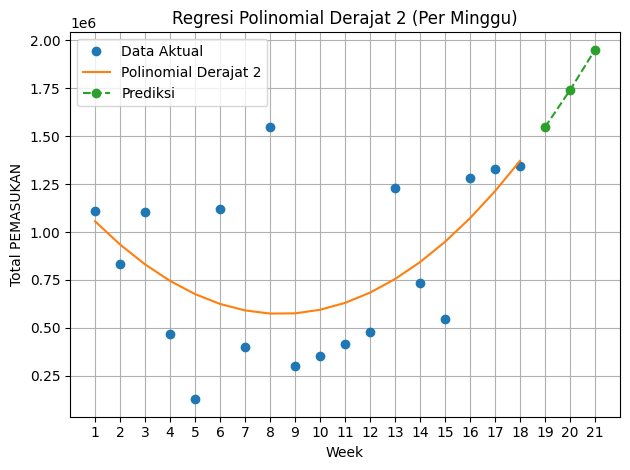


--- Polynomial Regression Degree 3 ---
R² Score: 0.2891
Prediksi 3 minggu ke depan:
Minggu 2025-14: Rp 1.625.216
Minggu 2025-15: Rp 1.868.480
Minggu 2025-16: Rp 2.141.536


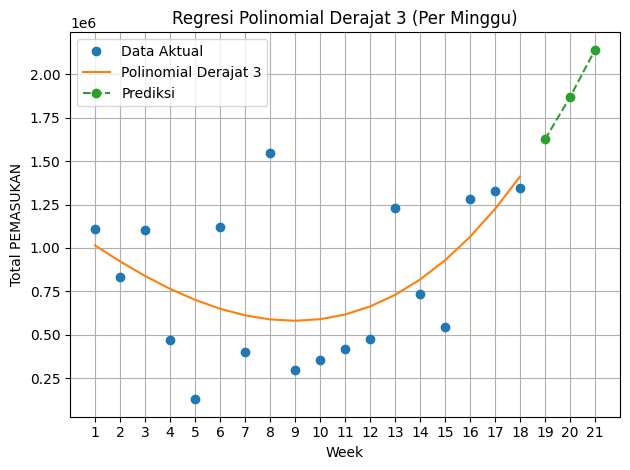


--- Polynomial Regression Degree 4 ---
R² Score: 0.2891
Prediksi 3 minggu ke depan:
Minggu 2025-14: Rp 1.625.536
Minggu 2025-15: Rp 1.868.496
Minggu 2025-16: Rp 2.141.344


<ipython-input-29-2973eae43602>:55: RankWarning: Polyfit may be poorly conditioned
  AB = np.polyfit(x, y, degree)


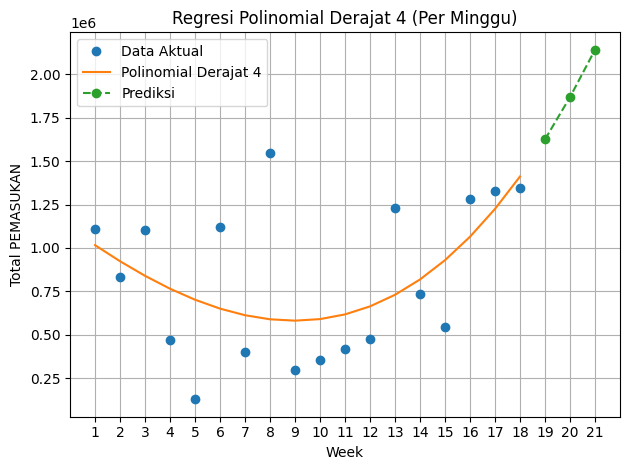

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSV
file_path = '/content/drive/MyDrive/UP/sample_data/rekapitulasi_saint_coffee_4_bulan.csv'
ct = pd.read_csv(file_path)

# Bersihkan dan standar kolom
ct.columns = ct.columns.str.strip().str.upper()
ct = ct.rename(columns={'TANGGAL': 'Tanggal', 'PEMASUKKAN': 'PEMASUKAN'})

# Konversi tanggal ke datetime
ct['Tanggal'] = pd.to_datetime(ct['Tanggal'], dayfirst=True)

# Konversi PEMASUKAN ke angka (hapus titik, koma, dan karakter non-angka jika perlu)
ct['PEMASUKAN'] = ct['PEMASUKAN'].replace('[^0-9]', '', regex=True).astype(float)

# Ambil tahun dan minggu dari tanggal
ct['Year'] = ct['Tanggal'].dt.isocalendar().year
ct['Week'] = ct['Tanggal'].dt.isocalendar().week

# Hitung total mingguan
weekly = ct.groupby(['Year', 'Week']).agg({'PEMASUKAN': 'sum'}).reset_index()
weekly['Transaksi_Numeric'] = weekly['Year'] + (weekly['Week'] / 52)

# Siapkan X dan Y
x = np.array(weekly['Transaksi_Numeric'])
y = np.array(weekly['PEMASUKAN'])

# Fungsi untuk menghitung R²
def compute_r2(y_true, y_predict):
    sse = sum((y_true - y_predict) ** 2)
    tss = (len(y_true) - 1) * np.var(y_true, ddof=1)
    return 1 - (sse / tss)

# Prediksi 3 minggu ke depan
last_year = weekly['Year'].max()
last_week = weekly[weekly['Year'] == last_year]['Week'].max()

future_dates = []
for i in range(1, 4):
    new_week = last_week + i
    new_year = last_year
    if new_week > 52:
        new_year += 1
        new_week -= 52
    future_numeric = new_year + (new_week / 52)
    future_dates.append(future_numeric)
x2 = np.array(future_dates)

# Forecast dengan polynomial regression (derajat 2, 3, 4)
for degree in [2, 3, 4]:
    print(f"\n--- Polynomial Regression Degree {degree} ---")
    AB = np.polyfit(x, y, degree)
    func = np.poly1d(AB)

    y_p = func(x)
    y_p2 = func(x2)

    r2 = compute_r2(y, y_p)
    print(f"R² Score: {r2:.4f}")
    print("Prediksi 3 minggu ke depan:")
    for trans, pred in zip(x2, y_p2):
        year = int(trans)
        week = int(round((trans - year) * 52))
        if week == 0:
            week = 52
            year -= 1
        print(f"Minggu {year}-{str(week).zfill(2)}: Rp {int(pred):,}".replace(",", "."))

    # Generate readable week labels like 'Week 1', 'Week 2', etc.
    week_labels = [f"{i+1}" for i in range(len(x))]
    future_labels = [f"{len(x) + i + 1}" for i in range(len(x2))]

    # Combine all labels and positions
    all_labels = week_labels + future_labels
    all_positions = np.concatenate([x, x2])

    # Combine all y values (for full plotting range)
    all_y = np.concatenate([y, y_p2])

    # Plot
    plt.plot(week_labels, y, linestyle="none", marker='o', label='Data Aktual')
    plt.plot(week_labels, y_p, label=f'Polinomial Derajat {degree}')
    plt.plot(future_labels, y_p2, marker='o', linestyle='dashed', label='Prediksi')

    plt.xlabel('Week')
    plt.ylabel('Total PEMASUKAN')
    plt.title(f'Regresi Polinomial Derajat {degree} (Per Minggu)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## NORMALIZATION + TRIMMING

<ipython-input-28-60d161c9af6e>:15: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  ct['Tanggal'] = pd.to_datetime(ct['Tanggal'], dayfirst=True)



--- Polynomial Regression Degree 2 ---
R² Score: 0.2866
Prediksi 4 minggu ke depan:
Minggu 2025-14: Rp 1.546.411
Minggu 2025-15: Rp 1.739.451
Minggu 2025-16: Rp 1.949.942


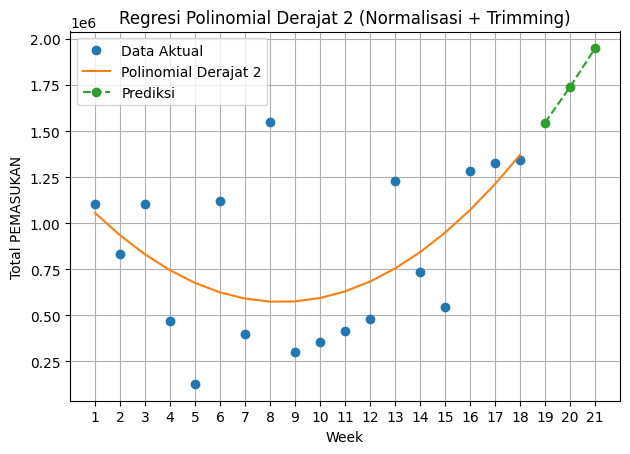


--- Polynomial Regression Degree 3 ---
R² Score: 0.2891
Prediksi 4 minggu ke depan:
Minggu 2025-14: Rp 1.624.962
Minggu 2025-15: Rp 1.868.202
Minggu 2025-16: Rp 2.141.298


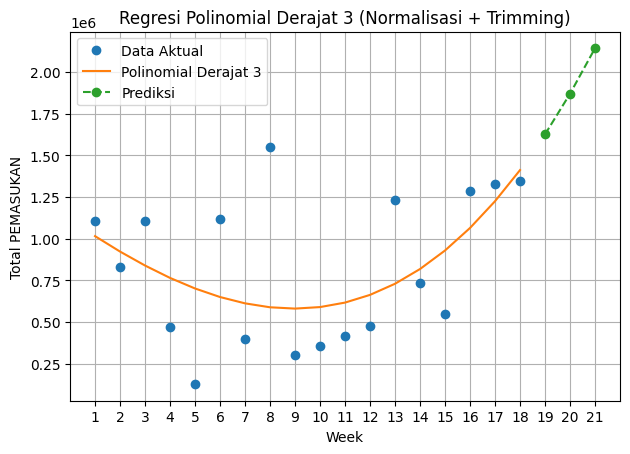


--- Polynomial Regression Degree 4 ---
R² Score: 0.2891
Prediksi 4 minggu ke depan:
Minggu 2025-14: Rp 1.625.591
Minggu 2025-15: Rp 1.868.527
Minggu 2025-16: Rp 2.141.385


<ipython-input-28-60d161c9af6e>:68: RankWarning: Polyfit may be poorly conditioned
  AB = np.polyfit(x, y_scaled, degree)


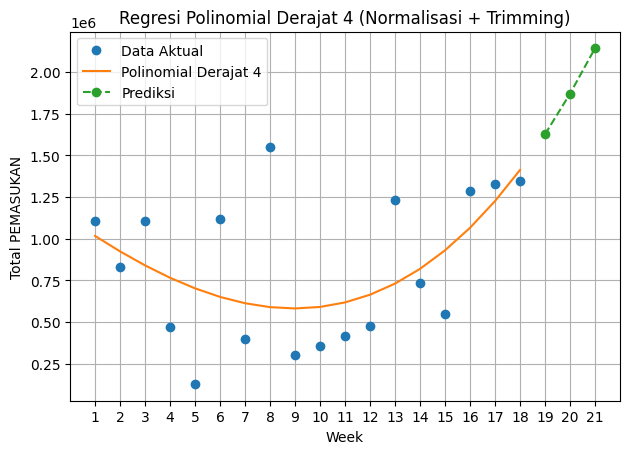

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load CSV
file_path = '/content/drive/MyDrive/UP/sample_data/rekapitulasi_saint_coffee_4_bulan.csv'
ct = pd.read_csv(file_path)

# Bersihkan dan standar kolom
ct.columns = ct.columns.str.strip().str.upper()
ct = ct.rename(columns={'TANGGAL': 'Tanggal', 'PEMASUKKAN': 'PEMASUKAN'})

# Konversi tanggal ke datetime
ct['Tanggal'] = pd.to_datetime(ct['Tanggal'], dayfirst=True)

# Konversi PEMASUKAN ke angka
ct['PEMASUKAN'] = ct['PEMASUKAN'].replace('[^0-9]', '', regex=True).astype(float)

# Ambil tahun dan minggu dari tanggal
ct['Year'] = ct['Tanggal'].dt.isocalendar().year
ct['Week'] = ct['Tanggal'].dt.isocalendar().week

# Hitung total mingguan
weekly = ct.groupby(['Year', 'Week']).agg({'PEMASUKAN': 'sum'}).reset_index()
weekly['Transaksi_Numeric'] = weekly['Year'] + (weekly['Week'] / 52)

# ------------------ REMOVE OUTLIERS (IQR Method) ------------------
Q1 = weekly['PEMASUKAN'].quantile(0.25)
Q3 = weekly['PEMASUKAN'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
weekly = weekly[(weekly['PEMASUKAN'] >= lower_bound) & (weekly['PEMASUKAN'] <= upper_bound)]

# Siapkan X dan Y
x = np.array(weekly['Transaksi_Numeric'])
y = np.array(weekly['PEMASUKAN'])

# ------------------ NORMALIZATION ------------------
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Fungsi untuk menghitung R²
def compute_r2(y_true, y_predict):
    sse = sum((y_true - y_predict) ** 2)
    tss = (len(y_true) - 1) * np.var(y_true, ddof=1)
    return 1 - (sse / tss)

# Prediksi 4 minggu ke depan
last_year = weekly['Year'].max()
last_week = weekly[weekly['Year'] == last_year]['Week'].max()

future_dates = []
for i in range(1, 4):
    new_week = last_week + i
    new_year = last_year
    if new_week > 52:
        new_year += 1
        new_week -= 52
    future_numeric = new_year + (new_week / 52)
    future_dates.append(future_numeric)
x2 = np.array(future_dates)

# Forecast dengan polynomial regression (derajat 2, 3, 4)
for degree in [2, 3, 4]:
    print(f"\n--- Polynomial Regression Degree {degree} ---")
    AB = np.polyfit(x, y_scaled, degree)
    func = np.poly1d(AB)

    y_p_scaled = func(x)
    y_p2_scaled = func(x2)

    # Balikkan ke skala asli
    y_p = scaler.inverse_transform(y_p_scaled.reshape(-1, 1)).flatten()
    y_p2 = scaler.inverse_transform(y_p2_scaled.reshape(-1, 1)).flatten()

    r2 = compute_r2(y, y_p)
    print(f"R² Score: {r2:.4f}")
    print("Prediksi 4 minggu ke depan:")
    for trans, pred in zip(x2, y_p2):
        year = int(trans)
        week = int(round((trans - year) * 52))
        if week == 0:
            week = 52
            year -= 1
        print(f"Minggu {year}-{str(week).zfill(2)}: Rp {int(pred):,}".replace(",", "."))

    # Label minggu untuk grafik
    week_labels = [f"{i+1}" for i in range(len(x))]
    future_labels = [f"{len(x) + i + 1}" for i in range(len(x2))]

    # Plot
    plt.plot(week_labels, y, linestyle="none", marker='o', label='Data Aktual')
    plt.plot(week_labels, y_p, label=f'Polinomial Derajat {degree}')
    plt.plot(future_labels, y_p2, marker='o', linestyle='dashed', label='Prediksi')

    plt.xlabel('Week')
    plt.ylabel('Total PEMASUKAN')
    plt.title(f'Regresi Polinomial Derajat {degree} (Normalisasi + Trimming)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Forecasting Daily

<ipython-input-18-a594f9587f50>:14: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  ct['Tanggal'] = pd.to_datetime(ct['Tanggal'], dayfirst=True)



--- Polynomial Regression Degree 2 ---
R² Score: 0.0727
Prediksi 14 hari ke depan:


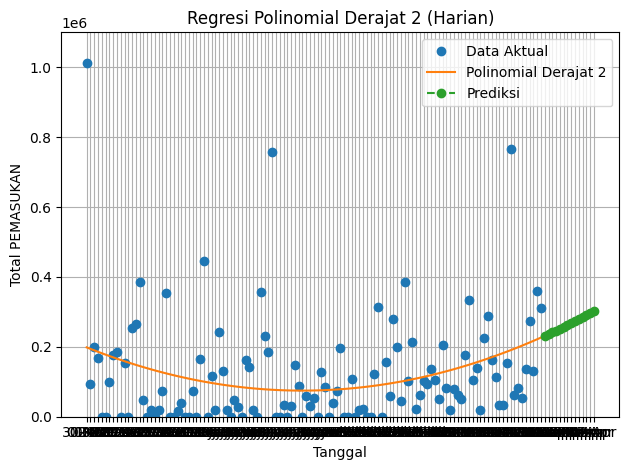


--- Polynomial Regression Degree 3 ---
R² Score: 0.0752
Prediksi 14 hari ke depan:


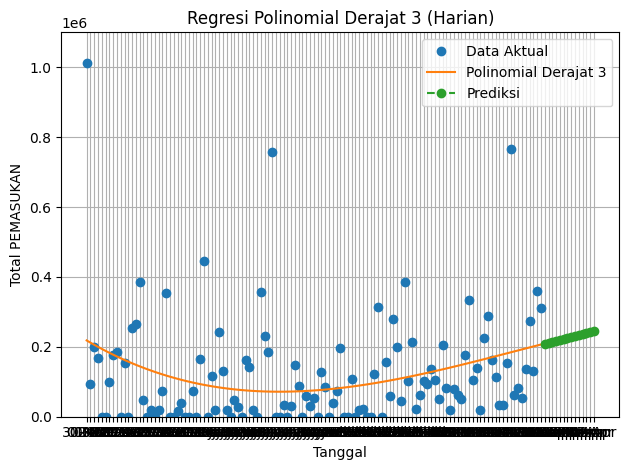


--- Polynomial Regression Degree 4 ---
R² Score: 0.1028
Prediksi 14 hari ke depan:


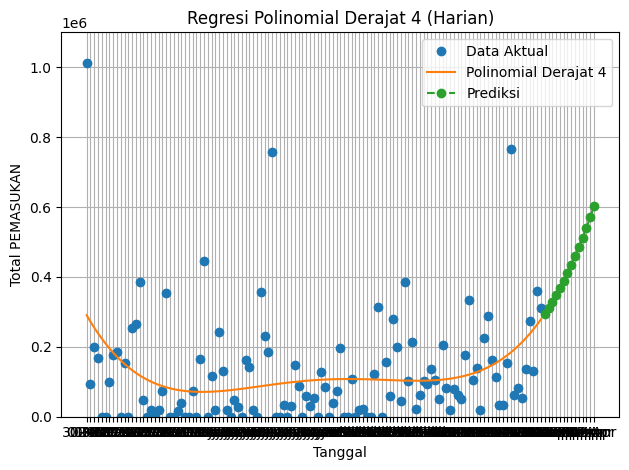

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSV
file_path = '/content/drive/MyDrive/UP/sample_data/rekapitulasi_saint_coffee_4_bulan.csv'
ct = pd.read_csv(file_path)

# Bersihkan dan standar kolom
ct.columns = ct.columns.str.strip().str.upper()
ct = ct.rename(columns={'TANGGAL': 'Tanggal', 'PEMASUKKAN': 'PEMASUKAN'})

# Konversi tanggal ke datetime
ct['Tanggal'] = pd.to_datetime(ct['Tanggal'], dayfirst=True)

# Konversi PEMASUKAN ke angka (hapus titik, koma, dan karakter non-angka jika perlu)
ct['PEMASUKAN'] = ct['PEMASUKAN'].replace('[^0-9]', '', regex=True).astype(float)

# Sort berdasarkan tanggal
ct = ct.sort_values('Tanggal')

# Ubah tanggal ke format numerik (misalnya: hari ke-n sejak hari pertama)
ct['Day_Index'] = (ct['Tanggal'] - ct['Tanggal'].min()).dt.days

# Siapkan X dan Y
x = np.array(ct['Day_Index'])
y = np.array(ct['PEMASUKAN'])

# Fungsi untuk menghitung R²
def compute_r2(y_true, y_predict):
    sse = sum((y_true - y_predict) ** 2)
    tss = (len(y_true) - 1) * np.var(y_true, ddof=1)
    return 1 - (sse / tss)

# Prediksi 14 hari ke depan
last_day = ct['Day_Index'].max()
future_days = [last_day + i for i in range(1, 15)]
x2 = np.array(future_days)
future_dates = [ct['Tanggal'].max() + pd.Timedelta(days=i) for i in range(1, 15)]

# Forecast dengan polynomial regression (derajat 2, 3, 4)
for degree in [2, 3, 4]:
    print(f"\n--- Polynomial Regression Degree {degree} ---")
    AB = np.polyfit(x, y, degree)
    func = np.poly1d(AB)

    y_p = func(x)
    y_p2 = func(x2)

    r2 = compute_r2(y, y_p)
    print(f"R² Score: {r2:.4f}")
    print("Prediksi 14 hari ke depan:")
    for date, pred in zip(future_dates, y_p2):
        print(f"Tanggal {date.strftime('%d-%b-%Y')}: Rp {int(pred):,}".replace(",", "."))

    # Label sumbu x sebagai tanggal
    all_labels = list(ct['Tanggal'].dt.strftime('%d-%b')) + [date.strftime('%d-%b') for date in future_dates]

    # Gabungkan semua x dan y untuk plotting
    all_x = np.concatenate([x, x2])
    all_y = np.concatenate([y, y_p2])

    # Plot
    plt.plot(all_labels[:len(y)], y, linestyle="none", marker='o', label='Data Aktual')
    plt.plot(all_labels[:len(y)], y_p, label=f'Polinomial Derajat {degree}')
    plt.plot(all_labels[len(y):], y_p2, marker='o', linestyle='dashed', label='Prediksi')

    plt.xlabel('Tanggal')
    plt.ylabel('Total PEMASUKAN')
    plt.ylim(top=1100000, bottom=0)  # Adjust this based on your data
    plt.title(f'Regresi Polinomial Derajat {degree} (Harian)')
    # plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## NORMALIZATION + TRIMMING

<ipython-input-25-69bc9572a5f9>:15: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  ct['Tanggal'] = pd.to_datetime(ct['Tanggal'], dayfirst=True)



--- Polynomial Regression Degree 2 ---
R² Score: 0.0992
Prediksi 14 hari ke depan:
Tanggal 31-Mar-2025: Rp 188.239
Tanggal 01-Apr-2025: Rp 191.757
Tanggal 02-Apr-2025: Rp 195.326
Tanggal 03-Apr-2025: Rp 198.944
Tanggal 04-Apr-2025: Rp 202.612
Tanggal 05-Apr-2025: Rp 206.330
Tanggal 06-Apr-2025: Rp 210.098
Tanggal 07-Apr-2025: Rp 213.916
Tanggal 08-Apr-2025: Rp 217.783
Tanggal 09-Apr-2025: Rp 221.700
Tanggal 10-Apr-2025: Rp 225.667
Tanggal 11-Apr-2025: Rp 229.684
Tanggal 12-Apr-2025: Rp 233.751
Tanggal 13-Apr-2025: Rp 237.867


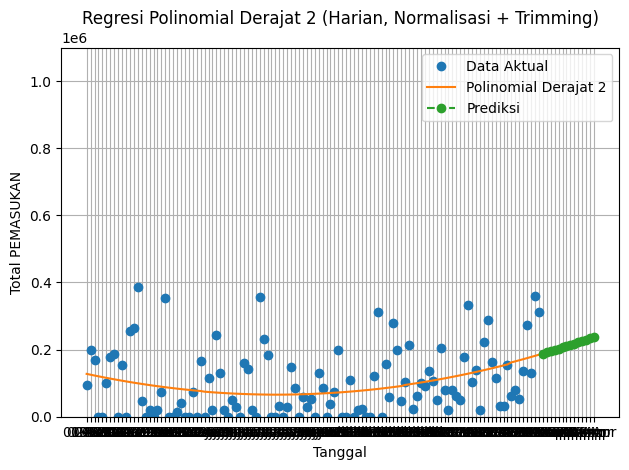


--- Polynomial Regression Degree 3 ---
R² Score: 0.0996
Prediksi 14 hari ke depan:
Tanggal 31-Mar-2025: Rp 193.723
Tanggal 01-Apr-2025: Rp 197.784
Tanggal 02-Apr-2025: Rp 201.917
Tanggal 03-Apr-2025: Rp 206.122
Tanggal 04-Apr-2025: Rp 210.400
Tanggal 05-Apr-2025: Rp 214.751
Tanggal 06-Apr-2025: Rp 219.175
Tanggal 07-Apr-2025: Rp 223.674
Tanggal 08-Apr-2025: Rp 228.246
Tanggal 09-Apr-2025: Rp 232.894
Tanggal 10-Apr-2025: Rp 237.616
Tanggal 11-Apr-2025: Rp 242.413
Tanggal 12-Apr-2025: Rp 247.286
Tanggal 13-Apr-2025: Rp 252.235


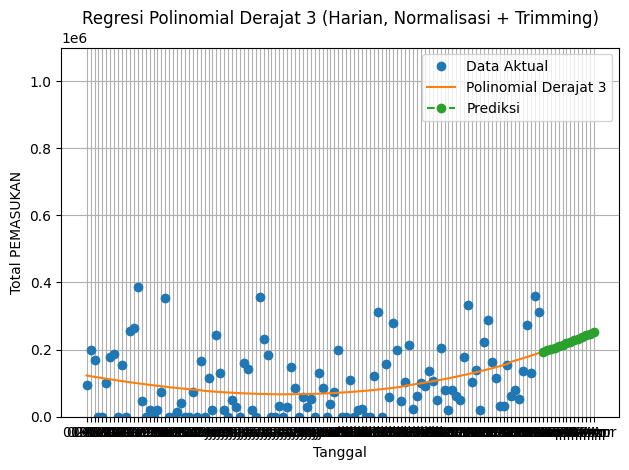


--- Polynomial Regression Degree 4 ---
R² Score: 0.1021
Prediksi 14 hari ke depan:
Tanggal 31-Mar-2025: Rp 209.949
Tanggal 01-Apr-2025: Rp 216.697
Tanggal 02-Apr-2025: Rp 223.717
Tanggal 03-Apr-2025: Rp 231.014
Tanggal 04-Apr-2025: Rp 238.598
Tanggal 05-Apr-2025: Rp 246.476
Tanggal 06-Apr-2025: Rp 254.657
Tanggal 07-Apr-2025: Rp 263.149
Tanggal 08-Apr-2025: Rp 271.960
Tanggal 09-Apr-2025: Rp 281.100
Tanggal 10-Apr-2025: Rp 290.577
Tanggal 11-Apr-2025: Rp 300.400
Tanggal 12-Apr-2025: Rp 310.577
Tanggal 13-Apr-2025: Rp 321.119


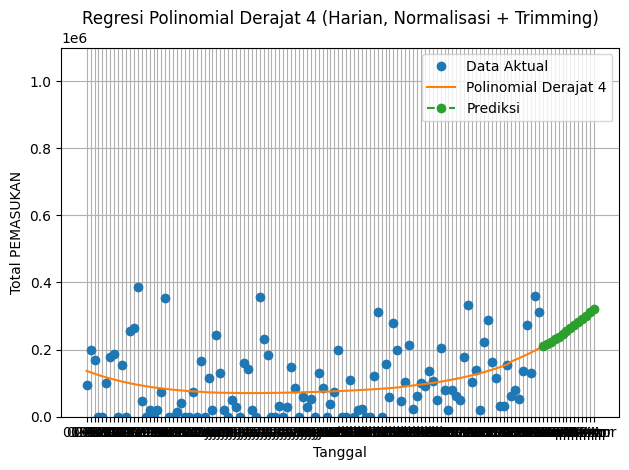

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load CSV
file_path = '/content/drive/MyDrive/UP/sample_data/rekapitulasi_saint_coffee_4_bulan.csv'
ct = pd.read_csv(file_path)

# Bersihkan dan standar kolom
ct.columns = ct.columns.str.strip().str.upper()
ct = ct.rename(columns={'TANGGAL': 'Tanggal', 'PEMASUKKAN': 'PEMASUKAN'})

# Konversi tanggal ke datetime
ct['Tanggal'] = pd.to_datetime(ct['Tanggal'], dayfirst=True)

# Konversi PEMASUKAN ke angka (hapus titik, koma, dan karakter non-angka jika perlu)
ct['PEMASUKAN'] = ct['PEMASUKAN'].replace('[^0-9]', '', regex=True).astype(float)

# Sort berdasarkan tanggal
ct = ct.sort_values('Tanggal')

# ------------------ REMOVE OUTLIERS (IQR Method) ------------------
Q1 = ct['PEMASUKAN'].quantile(0.25)
Q3 = ct['PEMASUKAN'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
ct = ct[(ct['PEMASUKAN'] >= lower_bound) & (ct['PEMASUKAN'] <= upper_bound)]

# Ubah tanggal ke format numerik (misalnya: hari ke-n sejak hari pertama)
ct['Day_Index'] = (ct['Tanggal'] - ct['Tanggal'].min()).dt.days

# Siapkan X dan Y
x = np.array(ct['Day_Index'])
y = np.array(ct['PEMASUKAN'])

# ------------------ NORMALIZATION ------------------
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Fungsi untuk menghitung R²
def compute_r2(y_true, y_predict):
    sse = sum((y_true - y_predict) ** 2)
    tss = (len(y_true) - 1) * np.var(y_true, ddof=1)
    return 1 - (sse / tss)

# Prediksi 14 hari ke depan
last_day = ct['Day_Index'].max()
future_days = [last_day + i for i in range(1, 15)]
x2 = np.array(future_days)
future_dates = [ct['Tanggal'].max() + pd.Timedelta(days=i) for i in range(1, 15)]

# Forecast dengan polynomial regression (derajat 2, 3, 4)
for degree in [2, 3, 4]:
    print(f"\n--- Polynomial Regression Degree {degree} ---")
    AB = np.polyfit(x, y_scaled, degree)
    func = np.poly1d(AB)

    y_p_scaled = func(x)
    y_p2_scaled = func(x2)

    # Balikkan hasil prediksi ke skala asli
    y_p = scaler.inverse_transform(y_p_scaled.reshape(-1, 1)).flatten()
    y_p2 = scaler.inverse_transform(y_p2_scaled.reshape(-1, 1)).flatten()

    r2 = compute_r2(y, y_p)
    print(f"R² Score: {r2:.4f}")
    print("Prediksi 14 hari ke depan:")
    for date, pred in zip(future_dates, y_p2):
        print(f"Tanggal {date.strftime('%d-%b-%Y')}: Rp {int(pred):,}".replace(",", "."))

    # Label sumbu x sebagai tanggal
    all_labels = list(ct['Tanggal'].dt.strftime('%d-%b')) + [date.strftime('%d-%b') for date in future_dates]

    # Plot
    plt.plot(all_labels[:len(y)], y, linestyle="none", marker='o', label='Data Aktual')
    plt.plot(all_labels[:len(y)], y_p, label=f'Polinomial Derajat {degree}')
    plt.plot(all_labels[len(y):], y_p2, marker='o', linestyle='dashed', label='Prediksi')

    plt.xlabel('Tanggal')
    plt.ylabel('Total PEMASUKAN')
    plt.ylim(top=1100000, bottom=0)
    plt.title(f'Regresi Polinomial Derajat {degree} (Harian, Normalisasi + Trimming)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
